In [9]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [10]:
datapath = "/home/tgroves/projects/gpu-comm/results/summit/validation/"


We need to extract the message size, and the time spent in each communication for a file.

Some of the gets are local gets.  We can tell because the bandwidth is 10X theoretical:

4 Node:

RANK(0) 0'th sync is 0.000043 (386.999815 GB/s, FAST)

RANK(3) 1'th sync is 0.000042 (399.847851 GB/s, FAST)

9 Node:

RANK(0) 0'th sync is 0.000049 (151.669830 GB/s, FAST)

RANK(4) 2'th sync is 0.000053 (141.170472 GB/s, FAST)

RANK(8) 1'th sync is 0.000048 (156.615481 GB/s, FAST)

16 Node:

RANK(15) 1'th sync is 0.000036 (118.019753 GB/s, FAST)

RANK(0) 0'th sync is 0.000034 (123.645540 GB/s, FAST)

RANK(5) 3'th sync is 0.000034 (123.536287 GB/s, FAST)

RANK(10) 2'th sync is 0.000034 (122.486464 GB/s, FAST)

In [11]:
def getValidationData(filepath, nodes=4):
    get_next = False
    times = []
    elem_szs = []
    elem_sz = 0
    with open(filepath) as f:
        for line in f.readlines():
            if get_next == True:
                get_next = False
                tmp = line.split()
                elem_sz = int(tmp[0]) * int(tmp[2])/nodes
            if line.startswith("=== MATRIX INFO ==="):
                get_next = True
            if line.startswith("RANK(") and "sync" in line:
                #Done to remove local memory copies
                if "RANK(3) 1'th sync" not in line and "RANK(0) 0'th sync" not in line and nodes==4:
                    times.append(float(line.split()[4]))
                    elem_szs.append(elem_sz)
                elif "RANK(0) 0'th sync" not in line and "RANK(4) 2'th sync" not in line \
                and "RANK(8) 1'th sync" not in line and nodes==9:
                    times.append(float(line.split()[4]))
                    elem_szs.append(elem_sz)
                elif "RANK(15) 1'th sync" not in line and "RANK(0) 0'th sync" not in line \
                and "RANK(5) 3'th" not in line and "RANK(10) 2'th" not in line and nodes==16:
                    times.append(float(line.split()[4]))
                    elem_szs.append(elem_sz)
    return elem_szs, times

In [12]:
#Returns communication time in nanoseconds
#If our application issues single messages, i.e. not throughput or message rate bound.
def timeToGetMessageSummit(m, h_or_d="default", verbose=False):
    #LogGOP parameter values NVSHMEM Host Initiated (ns)
    L_nvshmem_hi = 530
    o_nvshmem_hi = 247
    O_nvshmem_hi = 0.067 * m
    g_nvshmem_hi = 5
    G_nvshmem_hi = m / NETWORKBWGBPS
    S_nvshmem_hi = 0

    #LogGOP parameter values NVSHMEM Dev. Initiated (ns)
    L_nvshmem_di = 530
    o_nvshmem_di = 237
    O_nvshmem_di = 0
    g_nvshmem_di = 5
    G_nvshmem_di = m / NETWORKBWGBPS
    S_nvshmem_di = 4570
    
    #LogGOP parameter values IB verbs and DRAM (ns)
    L_nvshmem_dram = 280
    o_nvshmem_dram = 1400
    O_nvshmem_dram = 0.081 * m
    g_nvshmem_dram = 5
    G_nvshmem_dram = m / NETWORKBWGBPS
    
    if h_or_d == "d":
        if verbose:
            print("2L:{} 4o:{} 4g:{} 2G:{} 2S:{}".format(2*L_nvshmem_di , 4*o_nvshmem_di , 4*g_nvshmem_di , 2*G_nvshmem_di, 2*S_nvshmem_di))
        return 2*L_nvshmem_di + 4*o_nvshmem_di + 4*g_nvshmem_di + 2*G_nvshmem_di + 2*S_nvshmem_di

    elif h_or_d == "h":
        if verbose:
            print("2L:{} 4o:{} 2O:{} 4g:{} 2G:{} KernelLaunch:{}".format(2*L_nvshmem_hi , 4*o_nvshmem_hi , 2*O_nvshmem_hi , 4*g_nvshmem_hi , 2*G_nvshmem_hi , (GPUKERNELUS * 1000)))
        return 2*L_nvshmem_hi + 4*o_nvshmem_hi + 4*g_nvshmem_hi + max([2*G_nvshmem_hi,2*O_nvshmem_hi]) + (GPUKERNELUS * 1000)
        #return 2*L_nvshmem_hi + 4*o_nvshmem_hi + 4*g_nvshmem_hi + 2*G_nvshmem_hi + 2*O_nvshmem_hi + (GPUKERNELUS * 1000)

    #default MPI performance
    else:
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_dram , o_nvshmem_dram , O_nvshmem_dram , g_nvshmem_dram , G_nvshmem_dram ))
        return L_nvshmem_dram + o_nvshmem_dram + O_nvshmem_dram + g_nvshmem_dram + G_nvshmem_dram

In [13]:
#Returns communication time in nanoseconds
#If our application issues single messages, i.e. not throughput or message rate bound.
def timeToGetMessageSummitPipelined(m, h_or_d="default", verbose=False):
    #LogGOP parameter values NVSHMEM Host Initiated (ns)
    L_nvshmem_hi = 0
    o_nvshmem_hi = 0
    O_nvshmem_hi = (624 * m**(-1.09))
    g_nvshmem_hi = 5
    G_nvshmem_hi = m / NETWORKBWGBPS
    S_nvshmem_hi = 0
    #LogGOP parameter values NVSHMEM Dev. Initiated (ns)
    L_nvshmem_di = 0
    o_nvshmem_di = 0
    O_nvshmem_di = 1411 * m**(-0.781)
    g_nvshmem_di = 5
    G_nvshmem_di = m / NETWORKBWGBPS
    S_nvshmem_di = 0
    #LogGOP parameter values IB verbs and DRAM (ns)
    L_nvshmem_dram = 0
    o_nvshmem_dram = 0
    O_nvshmem_dram = 290 * m**(-1.15)
    g_nvshmem_dram = 5
    G_nvshmem_dram = m / NETWORKBWGBPS
    
    if h_or_d == "d":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_di , o_nvshmem_di , O_nvshmem_di , g_nvshmem_di , G_nvshmem_di))
        return L_nvshmem_di + o_nvshmem_di + max([O_nvshmem_di, (g_nvshmem_di + G_nvshmem_di)])
        #return L_nvshmem_di + o_nvshmem_di + O_nvshmem_di + g_nvshmem_di + G_nvshmem_di
                    
    elif h_or_d == "h":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{} KernelLaunch:{}".format(L_nvshmem_hi , o_nvshmem_hi , O_nvshmem_hi , g_nvshmem_hi , G_nvshmem_hi , (GPUKERNELUS * 1000)))
        return L_nvshmem_hi + o_nvshmem_hi + max([O_nvshmem_hi, (g_nvshmem_hi + G_nvshmem_hi)])
    #default MPI performance
    else:
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_dram , o_nvshmem_dram , O_nvshmem_dram , g_nvshmem_dram , G_nvshmem_dram ))
        return L_nvshmem_dram + o_nvshmem_dram + max([O_nvshmem_dram, (g_nvshmem_dram + G_nvshmem_dram)])

In [14]:
def SST(samples):
    y_bar = 0
    for x, y_i in samples:
        y_bar += y_i
    y_bar /= len(samples)
    tmp = 0
    for x, y_i in samples:
        tmp += (y_i - y_bar)**2
    return tmp

def SSReg(samples, pipelined=False):
    y_bar = 0
    for x, y_i in samples:
        y_bar += y_i
    y_bar /= len(samples)
    tmp = 0
    for x, y_i in samples:
        if pipelined:
            tmp += ((timeToGetMessageSummitPipelined(x*4, 'h')*2)/1e9 - y_bar)**2
        else:
            tmp += ((timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_bar)**2
    return tmp

def SSRes(samples, pipelined=False):
    tmp = 0
    for x, y_i in samples:
        if pipelined:
            tmp += ((timeToGetMessageSummitPipelined(x*4, 'h')*2)/1e9 - y_i)**2
        else:
            tmp += ((timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_i)**2
        #print("diff b/n model and sample {} - {} = {}".format(
        #(timeToGetMessageSummit(x*4, 'h')*2)/1e9, y_i, (timeToGetMessageSummit(x*4, 'h')*2)/1e9 - y_i ))
    return tmp



In [15]:
x

NameError: name 'x' is not defined

[64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0, 64.0]
[256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0, 256.0]
[1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1

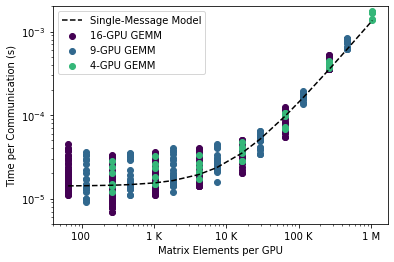

In [26]:
CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary
message_size = 8
comp_frac = 0.5
comm_frac = 1-comp_frac

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

import matplotlib.pylab as pl

n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))

fig, ax = plt.subplots()

xs2 = []
import itertools
color = 0
meandiffs = []
for nodes in [16,9,4]:
    files = ["matrix_test_simple.{}.{}.out".format(nodes, elems) for elems in [2**i for i in range(5,12)]]
    #files = ["matrix_test_simple.{}.v2.warmup1000flush.out".format(elems) for elems in [2**i for i in range(6,12)]]
    #files = ["matrix_test.{}.repeat100.nvprof".format(elems) for elems in [2**i for i in range(6,12)]]
    #files = ["matrix_test.{}.nvprof".format(elems) for elems in [2**i for i in range(6,12)]]

    xs = []
    ys = []
    data = {}
    for f in files:
        x, y = getValidationData(join(datapath, f), nodes=nodes)
        meandiffs.append(max(y)-min(y))
        print(x)
        xs+=x
        ys+=y
        #R^2 for each message size
        sst = SST(list(zip(x,y)))
        ssreg = SSReg(list(zip(x,y)))
        ssres = SSRes(list(zip(x,y)))
        #print("Elem. Sz.:{} SSRes/SST: {}".format(x[0],1-ssres/sst))
    
    ax.scatter(xs,ys, color=colors[color], label="{}-GPU GEMM".format(nodes))
    color+=1
    sst = SST(list(zip(xs,ys)))
    ssreg = SSReg(list(zip(xs,ys)), pipelined=False)
    ssres = SSRes(list(zip(xs,ys)),pipelined=False)
    print("Full Data SSRes/SST: {}".format(1-ssres/sst))
    xs2 += xs
xs2 = sorted(list(set(xs2)))
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [(timeToGetMessageSummit(x*4, 'h', verbose=True)*2)/1e9]
ax.plot(xs2,ys2, 'k--', label="Single-Message Model")

plt.ylim(bottom=0.000005, top=0.002)
plt.loglog()
plt.legend()
ax.set_ylabel("Time per Communication (s)")
ax.set_xlabel("Matrix Elements per GPU")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Pipelined, Aync. Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
fig.savefig("SimpleValidation.png")

In [29]:
np.mean(meandiffs)

6.295238095238094e-05

Pipelined Full Data SSRes/SST: 0.3261041383318293
Single Full Data SSRes/SST: -0.2808660614018994
Pipelined Full Data SSRes/SST: 0.7522870526957905
Single Full Data SSRes/SST: -0.005109138707593441
Pipelined Full Data SSRes/SST: 0.8910113288030036
Single Full Data SSRes/SST: 0.5112479731373077


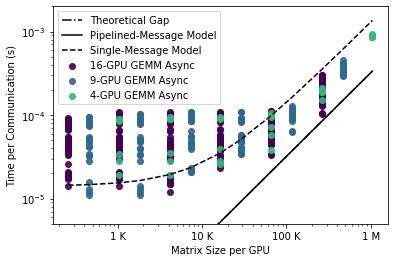

In [28]:
matplotlib.rc('image', cmap='viridis')
CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary
message_size = 8
comp_frac = 0.5
comm_frac = 1-comp_frac

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

import matplotlib.pylab as pl

n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))


fig, ax = plt.subplots()

xs2 = []

color = 0
for nodes in [16,9,4]:
    #files = ["matrix_test_simple.{}.{}.out".format(nodes, elems) for elems in [2**i for i in range(5,12)]]
    #files = ["matrix_test_simple.{}.v2.warmup1000flush.out".format(elems) for elems in [2**i for i in range(6,12)]]
    files = ["matrix_test2.{}.{}.out".format(nodes, elems) for elems in [2**i for i in range(6,12)]]
    #files = ["matrix_test.{}.nvprof".format(elems) for elems in [2**i for i in range(6,12)]]

    xs = []
    ys = []
    data = {}
    for f in files:
        x, y = getValidationData(join(datapath, f), nodes=nodes)
        xs+=x
        ys+=y
        #R^2 for each message size
        sst = SST(list(zip(x,y)))
        ssreg = SSReg(list(zip(x,y)))
        ssres = SSRes(list(zip(x,y)))
        #print("Elem. Sz.:{} SSRes/SST: {}".format(x[0],1-ssres/sst))
    ax.scatter(xs,ys, color=colors[color], label="{}-GPU GEMM Async".format(nodes), alpha=0.9)
    color += 1
    sst = SST(list(zip(xs,ys)))
    ssreg = SSReg(list(zip(xs,ys)), pipelined=True)
    ssres = SSRes(list(zip(xs,ys)),pipelined=True)
    print("Pipelined Full Data SSRes/SST: {}".format(1-ssres/sst))
    ssreg = SSReg(list(zip(xs,ys)), pipelined=False)
    ssres = SSRes(list(zip(xs,ys)),pipelined=False)
    print("Single Full Data SSRes/SST: {}".format(1-ssres/sst))
    xs2 += xs
xs2 = sorted(list(set(xs2)))
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [((x*4)/12.5e9)]
ax.plot(xs2,ys2, 'k-.', label="Theoretical Gap")
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [(timeToGetMessageSummitPipelined(x*4, 'h'))/1e9]
ax.plot(xs2,ys2, 'k-', label="Pipelined-Message Model")
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [(timeToGetMessageSummit(x*4, 'h')*2)/1e9]
ax.plot(xs2,ys2, 'k--', label="Single-Message Model")

plt.ylim(bottom=0.000005, top=0.002)
plt.loglog()
plt.legend()
plt.viridis()
ax.set_ylabel("Time per Communication (s)")
ax.set_xlabel("Matrix Size per GPU")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Pipelined, Aync. Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
#fig.savefig("AsyncValidation.png")

In [27]:
xs2

[256.0,
 455.1111111111111,
 1024.0,
 1820.4444444444443,
 4096.0,
 7281.777777777777,
 16384.0,
 29127.11111111111,
 65536.0,
 116508.44444444444,
 262144.0,
 466033.77777777775,
 1048576.0]

In [114]:
#bw = msgsz/time
#msgsz = bw * time
msgsz = 0.078866e9 * 0.000104
msgsz/(32*32)


8.009828125

In [142]:
matplotlib.rc('image', cmap='viridis')
CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary
message_size = 8
comp_frac = 0.5
comm_frac = 1-comp_frac

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

import matplotlib.pylab as pl

n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))


fig, ax = plt.subplots()

xs2 = []

color = 0
for nodes in [16,9,4]:
    #files = ["matrix_test_simple.{}.{}.out".format(nodes, elems) for elems in [2**i for i in range(5,12)]]
    #files = ["matrix_test_simple.{}.v2.warmup1000flush.out".format(elems) for elems in [2**i for i in range(6,12)]]
    files = ["matrix_test2.{}.{}.out".format(nodes, elems) for elems in [2**i for i in range(6,12)]]
    #files = ["matrix_test.{}.nvprof".format(elems) for elems in [2**i for i in range(6,12)]]

    xs = []
    ys = []
    data = {}
    for f in files:
        x, y = getValidationData(join(datapath, f), nodes=nodes)
        xs+=x
        ys+=y
        #R^2 for each message size
        sst = SST(list(zip(x,y)))
        ssreg = SSReg(list(zip(x,y)))
        ssres = SSRes(list(zip(x,y)))
        #print("Elem. Sz.:{} SSRes/SST: {}".format(x[0],1-ssres/sst))
    ax.scatter(xs,ys, color=colors[color], label="{}-GPU GEMM Async".format(nodes), alpha=0.9)
    color += 1
    sst = SST(list(zip(xs,ys)))
    ssreg = SSReg(list(zip(xs,ys)), pipelined=True)
    ssres = SSRes(list(zip(xs,ys)),pipelined=True)
    print("Pipelined Full Data SSRes/SST: {}".format(1-ssres/sst))
    ssreg = SSReg(list(zip(xs,ys)), pipelined=False)
    ssres = SSRes(list(zip(xs,ys)),pipelined=False)
    print("Single Full Data SSRes/SST: {}".format(1-ssres/sst))
    xs2 += xs
xs2 = sorted(list(set(xs2)))
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [(timeToGetMessageSummitPipelined(x*4, 'h')*2)/1e9]
ax.plot(xs2,ys2, 'k-', label="Pipelined-Message Model")
ys2 = []
for x in xs2:
    #x is number of elements.  4B/element * 2 gets
    ys2 += [(timeToGetMessageSummit(x*4, 'h')*2)/1e9]
ax.plot(xs2,ys2, 'k--', label="Single-Message Model")

plt.ylim(bottom=0.000005, top=0.002)
plt.loglog()
plt.legend()
plt.viridis()
ax.set_ylabel("Time per Communication (s)")
ax.set_xlabel("Elements per Grid Point")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Pipelined, Aync. Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()

[2e-05,
 1.5e-05,
 4.1e-05,
 1.7e-05,
 2.6e-05,
 2.3e-05,
 2e-05,
 3.9e-05,
 1.7e-05,
 2.1e-05,
 2.6e-05,
 3.3e-05,
 3.6e-05,
 5.9e-05,
 2.5e-05,
 4.4e-05,
 2.6e-05,
 4e-05,
 0.000101,
 0.000104,
 0.000107,
 7e-05,
 6.8e-05,
 0.000101,
 0.000362,
 0.000372,
 0.000393,
 0.000419,
 0.000378,
 0.00044,
 0.001401,
 0.001696,
 0.001728,
 0.001397,
 0.00167,
 0.001756]

In [108]:
print(xs)
print(y)

[1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 1024.0, 4096.0, 4096.0, 4096.0, 4096.0, 4096.0, 4096.0, 4096.0, 4096.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 16384.0, 65536.0, 65536.0, 65536.0, 65536.0, 65536.0, 65536.0, 65536.0, 65536.0, 262144.0, 262144.0, 262144.0, 262144.0, 262144.0, 262144.0, 262144.0, 262144.0, 1048576.0, 1048576.0, 1048576.0, 1048576.0, 1048576.0, 1048576.0, 1048576.0, 1048576.0]
[4.1e-05, 0.001401, 0.001696, 0.001728, 0.001397, 4.1e-05, 0.00167, 0.001756]


In [ ]:
from numpy.polynomial import polynomial as P
def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

fig, ax = plt.subplots()
labels = ["Verbs (CPU+DRAM)", "NVSHMEM Dev.-init.", "NVSHMEM Host-init."]
l = 0
for k in results.keys():
    xs = [int(x) for x in results[k].keys()]
    ys = [float(y) for y in results[k].values()]
    ys_mps = [(y*1e9)/x for (x,y) in zip(xs,ys)]
    #nanoseconds per message
    ys_nspm = [1e9/y for y in ys_mps]
    #nanoseconds per byte
    ys_nspb = [y/x for (x,y) in zip(xs,ys_nspm)]
    #print(list(zip(xs,ys_nspb)))
    lxs = np.log10(xs)
    lys = np.log10(ys_nspb)
    c = np.polyfit(lxs,lys,1)
    model_xs = np.linspace(min(xs), max(xs))
    poly = np.poly1d(c)
    model_ys = poly(model_xs)
    #print("{} {} {}".format(len(model_ys), len(ys_nspb), len(xs)))
    ax.plot(xs, ys_nspb, label=labels[l])
    for x_,y_ in (zip(xs,ys_nspb)):
        print("{}, {}".format(x_,y_))
    #ax.plot(model_xs, model_ys, label=labels[l])
    l += 1
plt.loglog()
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
ax.set_title("Amortized Time per Byte Sent for Varying Msg. Size\n (derived from pipelined get bandwdith)")
ax.set_ylabel("Time per Byte (ns)")
ax.set_xlabel("Message Size (B)")
ax.legend()
#ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylim(bottom=0.07)
plt.show()
fig.savefig("NSperByteGet.png")

In [ ]:
model_ys

In [ ]:
xs